In [1]:
# import libraries
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns 
import html
from bs4 import BeautifulSoup
import requests
import os
from selenium import webdriver
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import warnings; warnings.simplefilter('ignore')
from VE_scraper_functions import *
from chromedriver_py import binary_path # this will get you the path variable
from selenium.webdriver.common.by import By
import time
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Daniel.Lang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# import dataset
path = "park_scrape_content_dataset.xlsx"
park_scrape_dataset2 = pd.read_excel(path)
park_scrape_dataset2.head

<bound method NDFrame.head of        Unnamed: 0  index                                       website page                                            content website location  park
0               0      0  https://home.nps.gov/abli/planyourvisit/direct...  Directions - Abraham Lincoln Birthplace Nation...              NaN  ABLI
1               1      1  https://home.nps.gov/abli/planyourvisit/direct...  Directions - Abraham Lincoln Birthplace Nation...              NaN  ABLI
2               2      2  https://home.nps.gov/abli/planyourvisit/direct...  Directions - Abraham Lincoln Birthplace Nation...              NaN  ABLI
3               3      3  https://home.nps.gov/abli/planyourvisit/direct...  Directions - Abraham Lincoln Birthplace Nation...              NaN  ABLI
4               4      4  https://home.nps.gov/abli/planyourvisit/direct...  Directions - Abraham Lincoln Birthplace Nation...              NaN  ABLI
...           ...    ...                                              

In [3]:
## convert all text to lowercase to avoid case sensitivity issues
park_scrape_dataset2['content'] = park_scrape_dataset2['content'].str.lower()
park_scrape_dataset2.head

<bound method NDFrame.head of        Unnamed: 0  index                                       website page                                            content website location  park
0               0      0  https://home.nps.gov/abli/planyourvisit/direct...  directions - abraham lincoln birthplace nation...              NaN  ABLI
1               1      1  https://home.nps.gov/abli/planyourvisit/direct...  directions - abraham lincoln birthplace nation...              NaN  ABLI
2               2      2  https://home.nps.gov/abli/planyourvisit/direct...  directions - abraham lincoln birthplace nation...              NaN  ABLI
3               3      3  https://home.nps.gov/abli/planyourvisit/direct...  directions - abraham lincoln birthplace nation...              NaN  ABLI
4               4      4  https://home.nps.gov/abli/planyourvisit/direct...  directions - abraham lincoln birthplace nation...              NaN  ABLI
...           ...    ...                                              

In [4]:
RH_words =  [
       " uber " ," lyft ", "ridehailing", "ridesharing", " cab ", " taxi ","ride-hailing" , "ride-sharing" , "ride hailing" ,
    "ride sharing", "ride share"]

In [5]:
def count_RH_words(text):
    word_counts = {word: text.lower().count(word) for word in RH_words}
    return word_counts
word_counts_df = park_scrape_dataset2['content'].apply(count_RH_words).apply(pd.Series)
word_counts_df['total'] = word_counts_df.sum(axis=1)
word_counts_df.head()

,uber,lyft,ridehailing,ridesharing,cab,taxi,ride-hailing,ride-sharing,ride hailing,ride sharing,ride share,total
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
park_scrape_dataset2 = pd.concat([park_scrape_dataset2, word_counts_df], axis=1)
park_scrape_dataset2 = park_scrape_dataset2.drop("content", axis="columns")
park_scrape_dataset2.head

<bound method NDFrame.head of        Unnamed: 0  index                                       website page website location  park   uber    lyft   ridehailing  ridesharing   cab    taxi   ride-hailing  ride-sharing  ride hailing  ride sharing  ride share  total
0               0      0  https://home.nps.gov/abli/planyourvisit/direct...              NaN  ABLI       0       0            0            0      0       0             0             0             0             0           0      0
1               1      1  https://home.nps.gov/abli/planyourvisit/direct...              NaN  ABLI       0       0            0            0      0       0             0             0             0             0           0      0
2               2      2  https://home.nps.gov/abli/planyourvisit/direct...              NaN  ABLI       0       0            0            0      0       0             0             0             0             0           0      0
3               3      3  https://home.nps.gov

In [7]:
park_scrape_dataset2.to_csv("RHtest.csv")

In [8]:
path = "clusterlookup.csv"
clusters = pd.read_csv(path)
clusters.head

<bound method NDFrame.head of     Park Alpha                                      NPS Full Name Region  FinalCluster                    Label
0         ABLI  Abraham Lincoln Birthplace National Historical...    SER             8    Rural High Visitation
1         ACAD                               Acadia National Park    NER             1            Transit Parks
2         ADAM                     Adams National Historical Park    NER             1            Transit Parks
3         AFBG            African Burial Ground National Monument    NER             2              Urban Sites
4         AGFO                Agate Fossil Beds National Monument    MWR             7     Rural Low Visitation
..         ...                                                ...    ...           ...                      ...
383       WWIM                               World War I Memorial    NCR             2              Urban Sites
384       YELL                          Yellowstone National Park    IMR  

In [9]:
park_word_counts = park_scrape_dataset2.groupby('park')[RH_words].sum()
park_word_counts['total'] = park_word_counts.sum(axis=1)
park_word_counts.head

<bound method NDFrame.head of        uber    lyft   ridehailing  ridesharing   cab    taxi   ride-hailing  ride-sharing  ride hailing  ride sharing  ride share  total
park                                                                                                                                    
ABLI       0       0            0            0      0       0             0             0             0             0           0      0
ACAD       0       0            0            0      0       0             0             0             0             0           0      0
ADAM       0       0            0            0      0       0             0             0             0             0          21     21
AFBG       0       0            0            0      0       0             0             0             0             0           0      0
AGFO       0       0            0            0      0       0             0             0             0             0           0      0
...      ..

In [10]:
clustersubset = clusters[['Park Alpha', "FinalCluster", "Label"]]
clustersubset.rename(columns={'Park Alpha':"park"}, inplace = True)
clusterparks = pd.merge(park_word_counts, clustersubset, on="park", how="left")
clusterparks.head

<bound method NDFrame.head of      park   uber    lyft   ridehailing  ridesharing   cab    taxi   ride-hailing  ride-sharing  ride hailing  ride sharing  ride share  total  FinalCluster                    Label
0    ABLI       0       0            0            0      0       0             0             0             0             0           0      0           8.0    Rural High Visitation
1    ACAD       0       0            0            0      0       0             0             0             0             0           0      0           1.0            Transit Parks
2    ADAM       0       0            0            0      0       0             0             0             0             0          21     21           1.0            Transit Parks
3    AFBG       0       0            0            0      0       0             0             0             0             0           0      0           2.0              Urban Sites
4    AGFO       0       0            0            0      0       

In [11]:
clusterparks.to_csv("RHbypark.csv")

In [12]:
total_parks_counts = clusterparks.groupby('Label').size().reset_index(name='Total_Parks')
total_parks_counts['Total_Parks'] = total_parks_counts['Total_Parks'].astype(int) 
filtered_df = clusterparks[clusterparks['total'] > 1]
ev_parks_counts = filtered_df.groupby('Label').size().reset_index(name='RH_Parks')
label_counts = pd.merge(total_parks_counts, ev_parks_counts, on='Label', how='left')
label_counts['RH_Parks'].fillna(0, inplace=True)
label_counts['Percent_RH'] = round((label_counts['RH_Parks'] / label_counts['Total_Parks']) * 100, 1)
label_counts['RH_Parks'] = label_counts['RH_Parks'].astype(int)
label_counts.head()

,Label,Total_Parks,RH_Parks,Percent_RH
0,High Seasonal Variation,42,14,33.3
1,Low Visitation Sites,19,3,15.8
2,Rural High Visitation,63,7,11.1
3,Rural Low Visitation,72,3,4.2
4,Transit Parks,49,13,26.5


In [13]:
total_row = label_counts.sum(numeric_only=True)
total_row['Label'] = 'Total'
total_counts = label_counts.append(total_row, ignore_index=True)
total_counts['RH_Parks'] = total_counts['RH_Parks'].astype(int)
total_counts['Total_Parks'] = total_counts['Total_Parks'].astype(int)
total_counts.loc[total_counts['Label'] == 'Total', 'Percent_RH'] = round((total_counts.loc[total_counts['Label'] == 'Total', 'RH_Parks'] / total_counts.loc[total_counts['Label'] == 'Total', 'Total_Parks']) * 100, 1)
total_counts.tail()

,Label,Total_Parks,RH_Parks,Percent_RH
4,Transit Parks,49,13,26.5
5,Urban High Visitation,33,7,21.2
6,Urban Low Visitation,66,10,15.2
7,Urban Sites,36,0,0.0
8,Total,380,57,15.0


In [14]:
total_counts.to_csv("RHbycluster.csv")

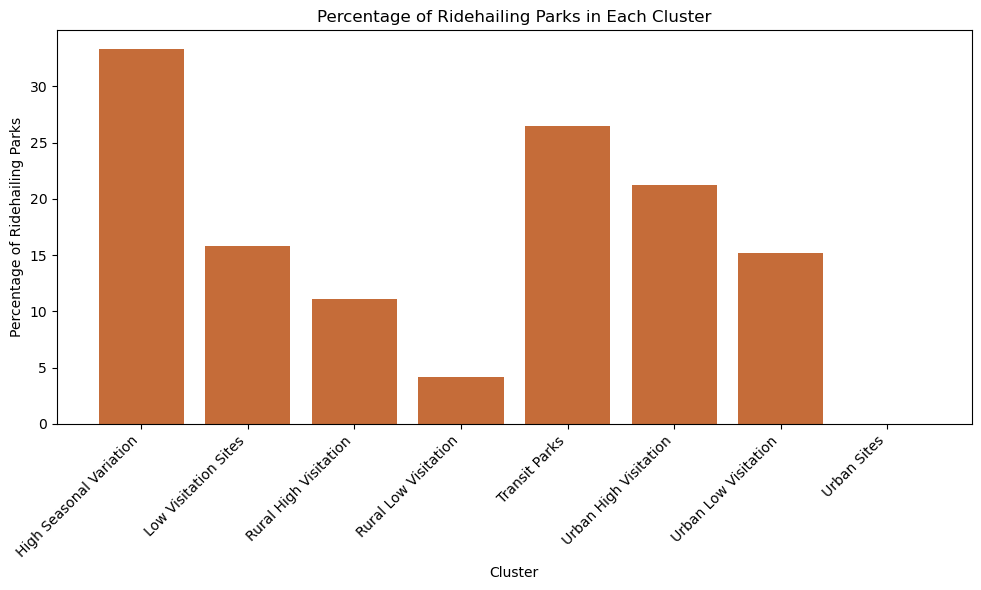

In [15]:
plt.figure(figsize=(10, 6)) 
plt.bar(label_counts['Label'], label_counts['Percent_RH'], color='#C56C39')
plt.xlabel('Cluster')
plt.ylabel('Percentage of Ridehailing Parks')
plt.title('Percentage of Ridehailing Parks in Each Cluster')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

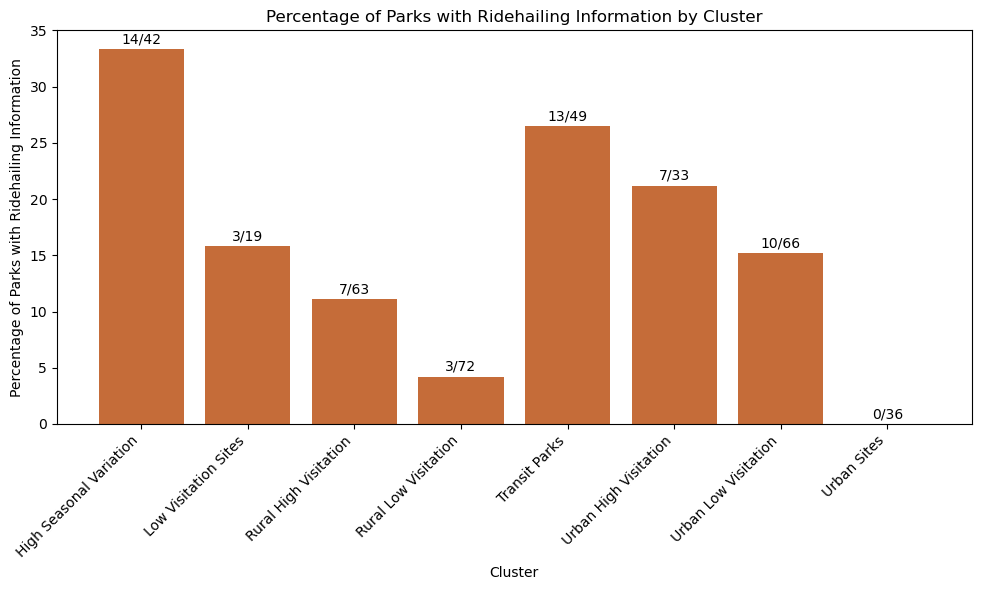

In [16]:
plt.figure(figsize=(10, 6)) 
bars = plt.bar(label_counts['Label'], label_counts['Percent_RH'], color='#C56C39')

for i, bar in enumerate(bars):
    ev_parks = label_counts['RH_Parks'].iloc[i]
    total_parks = label_counts['Total_Parks'].iloc[i]
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.25,
             f"{ev_parks}/{total_parks}",
             ha='center', va='bottom')
    
##avg_percent_ev = label_counts['Percent_EV'].mean()
##plt.axhline(y=avg_percent_ev, color='red', linestyle='--')

plt.xlabel('Cluster')
plt.ylabel('Percentage of Parks with Ridehailing Information')
plt.title('Percentage of Parks with Ridehailing Information by Cluster')
plt.xticks(rotation=45, ha='right') 
plt.ylim(0, 35)
plt.tight_layout()
plt.savefig("RHGraph.png")
plt.show()